In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import os

In [2]:
# Custom dataset to handle corrupted images
class SafeImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        while True:
            try:
                return super().__getitem__(index)
            except Exception:
                print(f"Skipping corrupted image at index {index}")
                index = (index + 1) % len(self.samples)

# Data transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load data with error handling
train_data = SafeImageFolder('../Data/train', transform=transform)
test_data = SafeImageFolder('../Data/test', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

print(f'Classes: {train_data.classes}')
print(f'Train samples: {len(train_data)}, Test samples: {len(test_data)}')

Classes: ['cats', 'dogs']
Train samples: 1402, Test samples: 300


In [3]:
# Load pre-trained ResNet
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f'Using device: {device}')

Using device: cpu


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(3):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 50 == 49:
            print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss/50:.4f}')
            running_loss = 0.0

Skipping corrupted image at index 630
Skipping corrupted image at index 630
Skipping corrupted image at index 630


In [5]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 89.33%


In [6]:
# Save model
torch.save(model.state_dict(), 'resnet_cats_dogs.pth')
print('Model saved!')

Model saved!


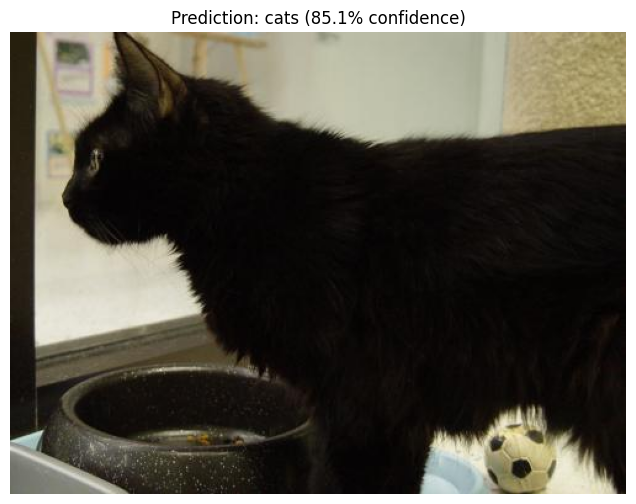

Predicted: cats with 85.1% confidence


In [7]:
# Prediction example
def predict_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            probabilities = torch.nn.functional.softmax(output[0], dim=0)
            predicted_class = torch.argmax(probabilities).item()
        
        class_names = ['cats', 'dogs']
        confidence = probabilities[predicted_class].item() * 100
        
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.title(f'Prediction: {class_names[predicted_class]} ({confidence:.1f}% confidence)')
        plt.axis('off')
        plt.show()
        
        return class_names[predicted_class], confidence
    except Exception as e:
        print(f'Error loading image: {e}')
        return None, 0

# Test prediction
sample_image = '../Data/test/cats/701.jpg'
prediction, confidence = predict_image(sample_image)
if prediction:
    print(f'Predicted: {prediction} with {confidence:.1f}% confidence')